Kaggle Competition: BBC News Classification 

Step 1: Extracting word features and show Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data
We will first define a class to handle csv files, implementing EDA and cleaning process.


In [265]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud

class DataAnalyzer:
    def __init__(self):
        self.train_data = None
        self.test_data = None


    def load_data(self, file_path, is_train=True):
        """
        Load data from a CSV file.
        
        :param file_path: str, path to the CSV file
        :param is_train: bool, True if loading training data, False otherwise
        :return: DataFrame, loaded data
        """
        data = pd.read_csv(file_path)
        if is_train:
            self.train_data = data
        else:
            self.test_data = data
        return data
    
    @staticmethod
    def show_basic_info(data):
        """
        Display basic information and statistics of the dataset.
        
        :param data: DataFrame, input data
        """
        print("Basic Information:")
        print(data.info())
        print("\nStatistical Summary:")
        print(data.describe())
        print("\nCategory Distribution:")
        print(data['Category'].value_counts())
    
    @staticmethod
    def plot_category_distribution(data):
        """
        Plot the distribution of article categories.
        
        :param data: DataFrame, input data
        """
        plt.figure(figsize=(10, 6))
        sns.countplot(x='Category', data=data, order=data['Category'].value_counts().index)
        plt.title('Category Distribution')
        plt.xlabel('Category')
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.show()
        
    @staticmethod
    def plot_text_length_distribution(data, target_column='Text'):
        """
        Plot the distribution of text lengths in the dataset.
        :param target_column: targeted column name
        :param data: DataFrame, input data
        """
        data['Text_Length'] = data[target_column].apply(len)
        plt.figure(figsize=(10, 6))
        sns.histplot(data['Text_Length'], bins=50, kde=True)
        plt.title('Text Length Distribution')
        plt.xlabel('Text Length')
        plt.ylabel('Frequency')
        plt.show()

    @staticmethod
    def show_word_frequencies(data, target_column='Text'):
        """
        Display the most common words and generate a word cloud.
        :param target_column: targeted column name
        :param data: DataFrame, input data
        """
        all_text = " ".join(data[target_column])
        words = all_text.split()
        word_counts = Counter(words)
        common_words = word_counts.most_common(20)
        
        print("\nMost Common 20 Words:")
        for word, count in common_words:
            print(f"{word}: {count}")

        wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate_from_frequencies(word_counts)
        plt.figure(figsize=(10, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title('Word Cloud')
        plt.axis('off')
        plt.show()

    def perform_eda(self, data, target_column='Text'):
        """
        Perform exploratory data analysis by calling individual EDA functions.
        :param target_column: targeted column name
        :param data: DataFrame, input data
        """
        self.show_basic_info(data)
        self.plot_category_distribution(data)
        self.plot_text_length_distribution(data, target_column=target_column)
        self.show_word_frequencies(data, target_column=target_column)
        

Basic Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB
None

Statistical Summary:
         ArticleId
count  1490.000000
mean   1119.696644
std     641.826283
min       2.000000
25%     565.250000
50%    1112.500000
75%    1680.750000
max    2224.000000

Category Distribution:
Category
sport            346
business         336
politics         274
entertainment    273
tech             261
Name: count, dtype: int64


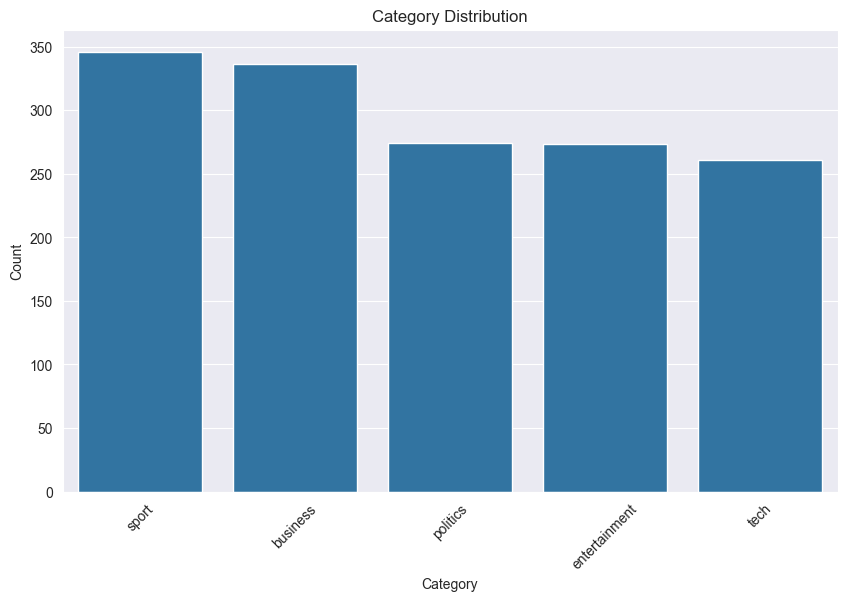

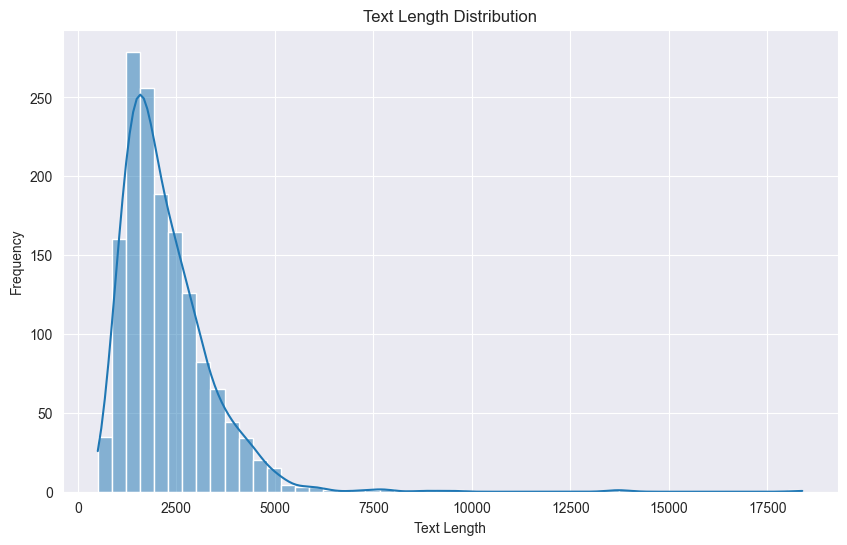


Most Common 20 Words:
the: 34992
to: 16568
of: 12970
and: 12366
a: 12102
in: 11696
s: 5899
for: 5773
is: 5478
that: 5207
it: 5000
on: 4991
was: 4019
he: 3866
be: 3803
with: 3482
said: 3401
has: 3250
as: 3245
have: 3133


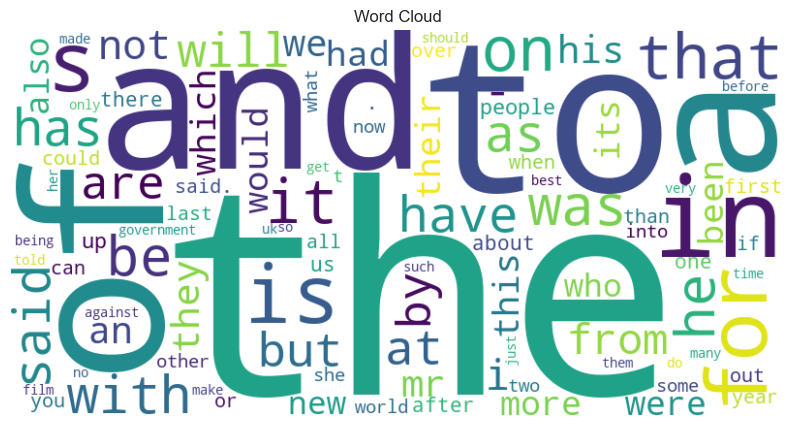

In [266]:
analyzer = DataAnalyzer()
train_data = analyzer.load_data('data/BBC News Train.csv', is_train=True)
test_data = analyzer.load_data('data/BBC News Test.csv', is_train=False)
analyzer.perform_eda(train_data)

According to the EDA above, we learn that each category has close weight to the whole data, and we learn that the text length does not distribute evenly, most of which has 1000-5000.
Besides, from the wordcloud plot, we learn that the most frequent words in English are empty words, such as 'the', 'is', 'and'. This kind of words, is called 'stop words', which means noise in text processing. Hence, removing such stop words is crucial in further implementation.
Furthermore, in English, a word may have multiple forms but with the same 'stem', which means the original form of the word. The application of lemmatization is implemented to transform word formation into the same word.


In [267]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

class DataCleaner(DataAnalyzer):
    def __init__(self, analyzer):
        super().__init__()
        self.__dict__.update(analyzer.__dict__)
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))
        
    @staticmethod
    def clean_data(data):
        """
        Clean the data by removing duplicates and missing values.
        
        :param data: DataFrame, input data
        :return: DataFrame, cleaned data
        """
        data_cleaned = data.dropna().drop_duplicates()
        return data_cleaned
    
    def preprocess_text(self, text):
        """
        Preprocess the text by removing stop words and applying lemmatization.
        
        :param text: str, input text
        :return: str, processed text
        """
        tokens = text.split()
        tokens = [self.lemmatizer.lemmatize(token) for token in tokens if token.lower() not in self.stop_words]
        return " ".join(tokens)
    
    def preprocess_texts(self, data):
        """
        Apply text preprocessing to each text in the DataFrame.
        
        :param data: DataFrame, input data
        :return: DataFrame, data with processed texts
        """
        data['Processed_Text'] = data['Text'].apply(self.preprocess_text)
        return data
        
    def data_process(self):
        """
        Perform data cleaning and text preprocessing.
        """
        # Clean the data
        self.train_data = self.clean_data(self.train_data)
        # Preprocess the texts
        self.train_data = self.preprocess_texts(self.train_data)
        if self.test_data is not None:
            self.test_data = self.clean_data(self.test_data)
            self.test_data = self.preprocess_texts(self.test_data)
    

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Basic Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ArticleId       1490 non-null   int64 
 1   Text            1490 non-null   object
 2   Category        1490 non-null   object
 3   Text_Length     1490 non-null   int64 
 4   Processed_Text  1490 non-null   object
dtypes: int64(2), object(3)
memory usage: 58.3+ KB
None

Statistical Summary:
         ArticleId   Text_Length
count  1490.000000   1490.000000
mean   1119.696644   2233.461745
std     641.826283   1205.153358
min       2.000000    501.000000
25%     565.250000   1453.000000
50%    1112.500000   1961.000000
75%    1680.750000   2751.250000
max    2224.000000  18387.000000

Category Distribution:
Category
sport            346
business         336
politics         274
entertainment    273
tech             261
Name: count, dtype: int64


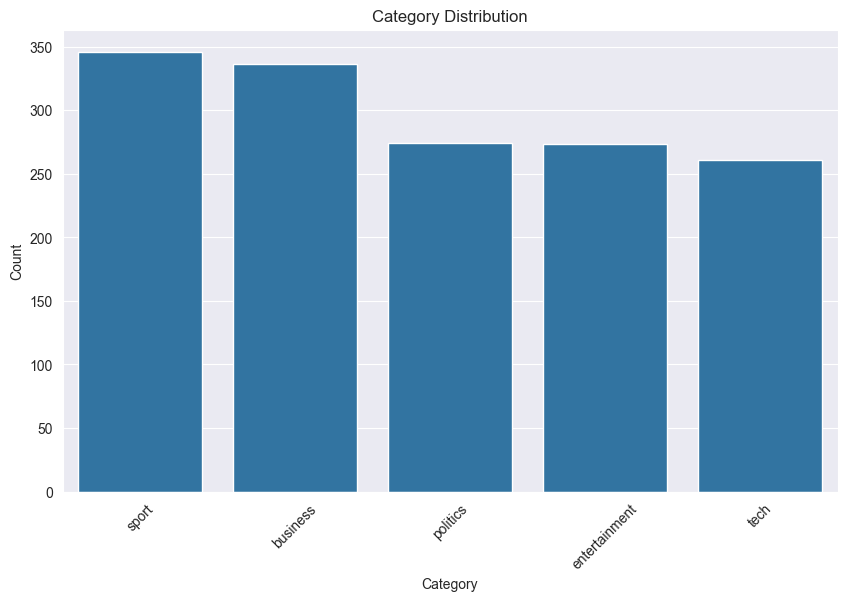

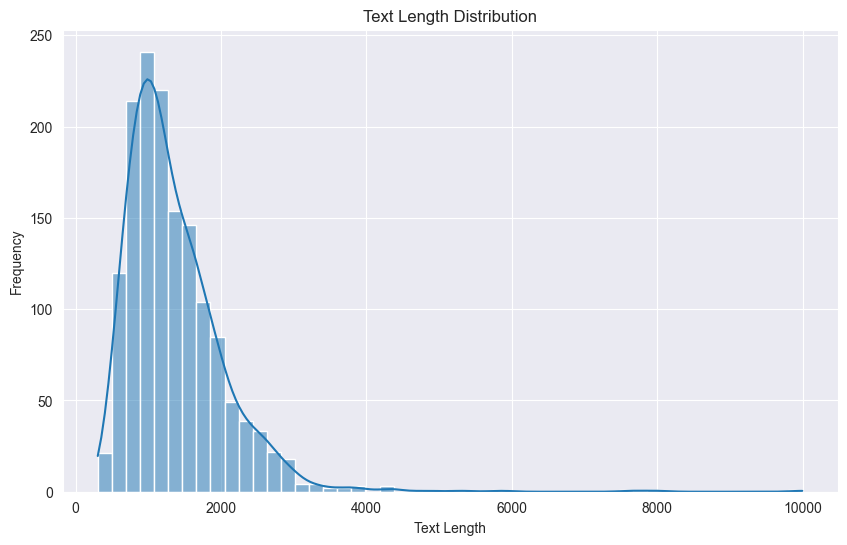


Most Common 20 Words:
win: 1023
game: 998
film: 815
world: 811
government: 771
uk: 757
play: 748
company: 682
firm: 676
see: 643
service: 617
add: 597
plan: 582
back: 581
include: 580
country: 564
market: 560
think: 560
month: 554
well: 546


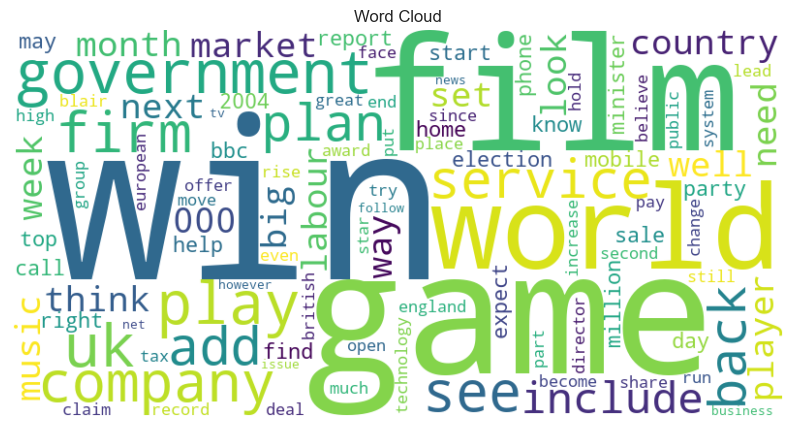

In [312]:
cleaner = DataCleaner(analyzer)
cleaner.data_process()
cleaner.perform_eda(cleaner.train_data, target_column='Processed_Text')

Based on the latest processing outcome, I realize that there are many punctuations and meaningless words (e.g. 'make') in the most frequent words, which require further filter. Besides, I notice that maybe upper and lower first letter should be unified as the same formation. I will update the preprocess_text() method of class.

In [307]:
# redefine the class DataCleaner
import string
from nltk import pos_tag, word_tokenize
from nltk.corpus import wordnet

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

class DataCleaner(DataAnalyzer):
    def __init__(self, analyzer):
        super().__init__()
        self.__dict__.update(analyzer.__dict__)
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))
        
    @staticmethod
    def clean_data(data):
        """
        Clean the data by removing duplicates and missing values.
        
        :param data: DataFrame, input data
        :return: DataFrame, cleaned data
        """
        data_cleaned = data.dropna().drop_duplicates()
        return data_cleaned
    
    def preprocess_text(self, text):
        """
        Preprocess the text by converting to lowercase, removing stop words, punctuation, high-frequency non-informative words, and applying lemmatization.
        
        :param text: str, input text
        :return: str, processed text
        """
        high_freq_words = {'said', 'mr', 'also', 'would', 'could', 'u', 'say', 'year', 'you', 'go', 'come', 'last', 'first', 'time', 'make', 'use', 'take', 'get', 'new', 'people', 'good', 'one', 'two', 'three', 'best', 'tell', 'show', 'work', 'want', 'give', 'like', 'many', 'number'}
        
        text = text.lower()
        text = text.translate(str.maketrans('', '', string.punctuation))
        tokens = word_tokenize(text)
        pos_tags = pos_tag(tokens)
        tokens = [self.lemmatizer.lemmatize(token, self.get_wordnet_pos(tag)) for token, tag in pos_tags]
        tokens = [word for word in tokens if word not in self.stop_words and word not in high_freq_words]
        return " ".join(tokens)
    
    @staticmethod
    def get_wordnet_pos(tag):
        if tag.startswith('J'):
            return wordnet.ADJ
        elif tag.startswith('V'):
            return wordnet.VERB
        elif tag.startswith('N'):
            return wordnet.NOUN
        elif tag.startswith('R'):
            return wordnet.ADV
        else:
            return wordnet.NOUN
        
    def preprocess_texts(self, data):
        """
        Apply text preprocessing to each text in the DataFrame.
        
        :param data: DataFrame, input data
        :return: DataFrame, data with processed texts
        """
        data['Processed_Text'] = data['Text'].apply(self.preprocess_text)
        return data
        
    def data_process(self):
        """
        Perform data cleaning and text preprocessing.
        """
        # Clean the data
        # Preprocess the texts
        self.train_data = self.clean_data(self.train_data)
        self.train_data = self.preprocess_texts(self.train_data)
        if self.test_data is not None:
            self.test_data = self.clean_data(self.test_data)
            self.test_data = self.preprocess_texts(self.test_data)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Basic Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ArticleId       1490 non-null   int64 
 1   Text            1490 non-null   object
 2   Category        1490 non-null   object
 3   Text_Length     1490 non-null   int64 
 4   Processed_Text  1490 non-null   object
dtypes: int64(2), object(3)
memory usage: 58.3+ KB
None

Statistical Summary:
         ArticleId   Text_Length
count  1490.000000   1490.000000
mean   1119.696644   2233.461745
std     641.826283   1205.153358
min       2.000000    501.000000
25%     565.250000   1453.000000
50%    1112.500000   1961.000000
75%    1680.750000   2751.250000
max    2224.000000  18387.000000

Category Distribution:
Category
sport            346
business         336
politics         274
entertainment    273
tech             261
Name: count, dtype: int64


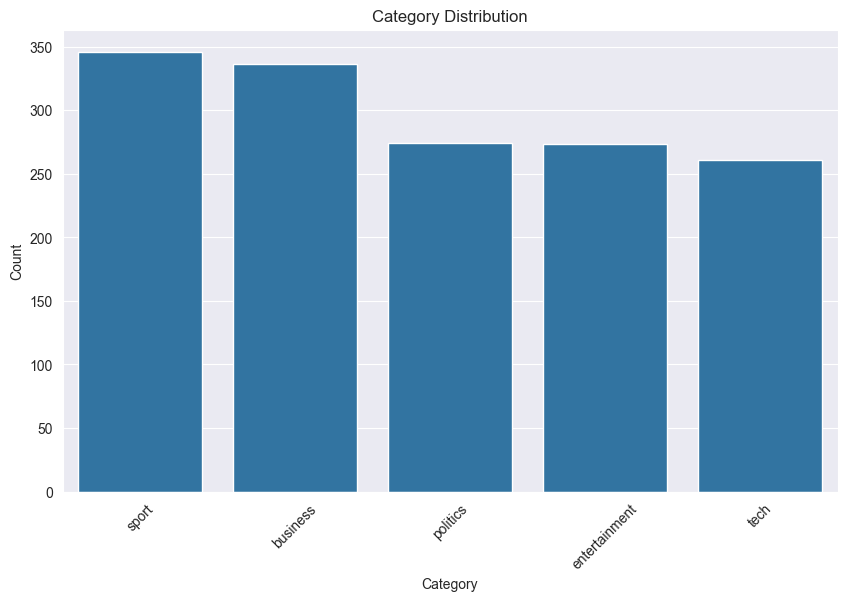

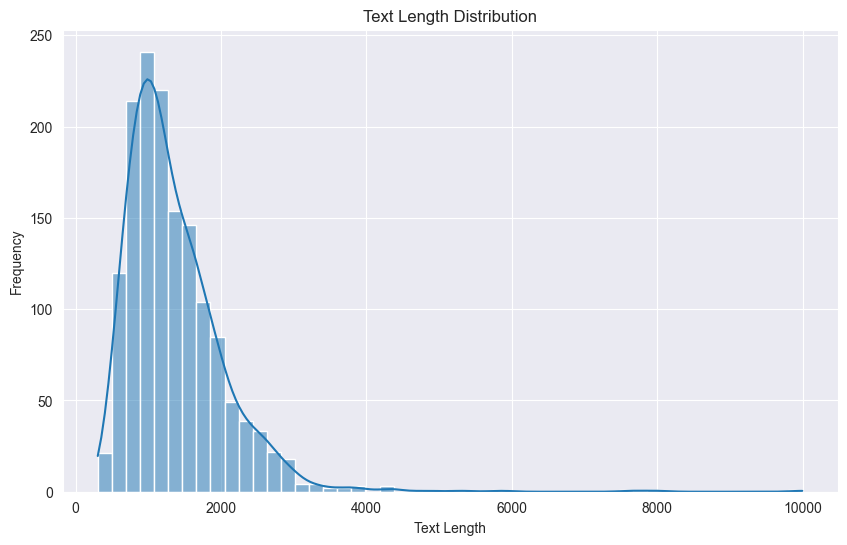


Most Common 20 Words:
win: 1023
game: 998
film: 815
world: 811
government: 771
uk: 757
play: 748
company: 682
firm: 676
see: 643
service: 617
add: 597
plan: 582
back: 581
include: 580
country: 564
market: 560
think: 560
month: 554
well: 546


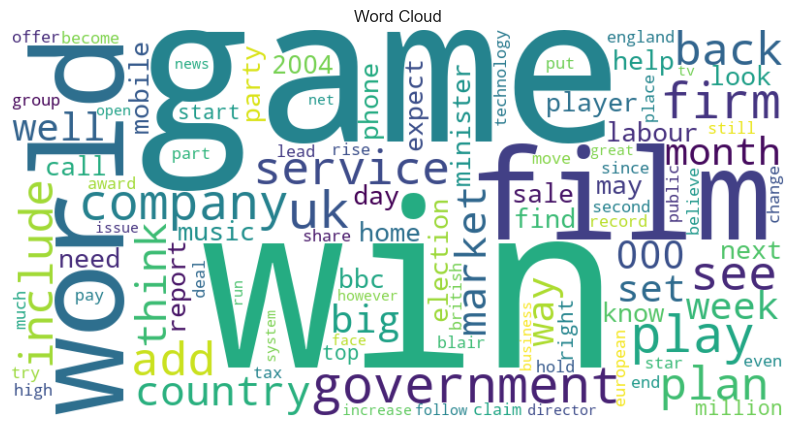

In [313]:
cleaner = DataCleaner(analyzer)
cleaner.data_process()
cleaner.perform_eda(cleaner.train_data, target_column='Processed_Text')

We may notice that the high_freq_words set need to be maintained manually, which is low efficient and mistakable. Now, I would then implement further process of feature extraction to lower the reliance on the high_freq_words set.
I learn that there are 2 main available approach of feature extraction in NLP, TF-IDF and word embedding. The first one focus on statistical feature of word frequency in each article id, and the second one focus on linguist feature of the meaning of texts.
I would like to establish two feature matrix to compare which one performs better in this problem and explore the possibility of combination of both statistical and linguist features.
First I would define a basic class.

In [318]:
# Basic class
import numpy as np
import spacy
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.feature_selection import chi2, SelectKBest
from scipy.sparse import csr_matrix
from sklearn.feature_selection import f_classif, SelectKBest


class FeatureExtractor:
    def __init__(self, cleaner):
        self.data = cleaner.train_data.copy()
        self.test_data = cleaner.test_data.copy()
        self.features = None
        self.W = None
        self.H = None
        self.model = None
        self.label_mapping = {}
        self.inverse_label_mapping = {}
        self.create_label_mapping()
        
    def extract_features(self):
        raise NotImplementedError("Subclasses should implement this method!")
    
    def create_label_mapping(self):
        unique_labels = self.data['Category'].unique()
        self.label_mapping = {label: idx for idx, label in enumerate(unique_labels)}
        self.inverse_label_mapping = {idx: label for idx, label in enumerate(unique_labels)}
        self.data['Category'] = self.data['Category'].map(self.label_mapping).astype(int)
        
    @staticmethod
    def visualize_features(features):
        if isinstance(features, csr_matrix):
            features = features.toarray()
    
        plt.figure(figsize=(10, 6))

        cmap = plt.cm.seismic

        norm = plt.Normalize(vmin=-np.max(np.abs(features)), vmax=np.max(np.abs(features)))
        plt.imshow(features, aspect='auto', interpolation='nearest', cmap=cmap, norm=norm)
        plt.colorbar() 
        plt.title('Feature Matrix Visualization')
        plt.xlabel('Features')
        plt.ylabel('Documents')
        plt.show()

    def feature_selection(self, labels, num_features=300):
        selector = SelectKBest(f_classif, k=num_features)
        self.features = selector.fit_transform(self.features, labels)
        return self.features
    
    def apply_matrix_factorization(self, n_components=5, method='NMF'):
        if method == 'NMF':
            model = NMF(n_components=n_components, init='random', random_state=0)
        elif method == 'SVD':
            model = TruncatedSVD(n_components=n_components)
        else:
            raise ValueError("Unsupported factorization method.")
        
        self.W = model.fit_transform(self.features)
        self.H = model.components_
        self.model = model
        return self.W, self.H

In the context of feature matrices used in natural language processing (NLP), the columns represent the features extracted from the text data. The nature of these features differs significantly between two common methods: TF-IDF and word embeddings. Here’s a summary of what the columns represent in each type of feature matrix:

TF-IDF Feature Matrix
1) Individual Columns: Each column in a TF-IDF feature matrix represents a unique word from the corpus.
2) Values in Columns: The values in these columns represent the TF-IDF score of each word for a given document. This score is a statistical measure used to evaluate how important a word is to a document in a collection or corpus. The importance increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus, which helps to adjust for the fact that some words appear more frequently in general.
3) Sparsity: TF-IDF matrices are typically sparse because not every word appears in every document, so many entries are zero, indicating the absence of the corresponding word in those documents.

Word Embedding Feature Matrix
1) Individual Columns: Each column in a feature matrix derived from word embeddings represents a dimension in the embedding space. Unlike TF-IDF, these dimensions do not correspond to specific, identifiable words.
2) Values in Columns: The values are continuous and represent the coordinates of the document's vector in the embedding space. These vectors are obtained by averaging (or another aggregation method) the embeddings of all the words in a document, resulting in a dense representation where each dimension reflects a composite of semantic and syntactic features learned during the training of the embeddings.
3) Dense Nature: Unlike TF-IDF, embedding matrices are dense, meaning most values are non-zero. Each dimension of the embeddings captures latent linguistic features that are not straightforward to interpret individually but collectively provide a rich, nuanced representation of text semantics.

To summarize, TF-IDF matrices are ideal for tasks where the individual importance of specific words (relative to their document and corpus-wide occurrences) is crucial. They are characterized by high dimensionality and sparsity.
Embedding matrices excel in tasks requiring an understanding of complex language patterns and relationships, supported by their dense and semantically rich nature. These matrices are particularly useful in deep learning models where contextual nuances are important. 
Let's define these two feature extraction tool.

In [319]:
# Subclass-TF-IDF
class TFIDFFeatureExtractor(FeatureExtractor):
    def __init__(self, data):
        super().__init__(data)
        self.vectorizer = TfidfVectorizer(max_df=0.7, min_df=5, stop_words='english')

    def extract_features(self):
        self.features = self.vectorizer.fit_transform(self.data['Processed_Text'])
        return self.features

# Subclass-Embedding
class EmbeddingFeatureExtractor(FeatureExtractor):
    def __init__(self, data):
        super().__init__(data)
        self.nlp = spacy.load('en_core_web_lg')

    def document_vector(self, doc):
        """Generate document vectors by averaging word vectors, handling cases where no word has a vector."""
        doc = self.nlp(doc)
        vectors = [word.vector for word in doc if not word.is_stop and word.has_vector]
        if vectors:
            return np.mean(vectors, axis=0)
        else:
            # Return a zero vector if no word has a vector
            return np.zeros((300,))  # 300 is the dimensionality of GloVe vectors in 'en_core_web_lg'

    def extract_features(self):
        """Use document_vector method to create feature matrix."""
        self.features = np.array([self.document_vector(text) for text in self.data['Processed_Text']])
        return self.features


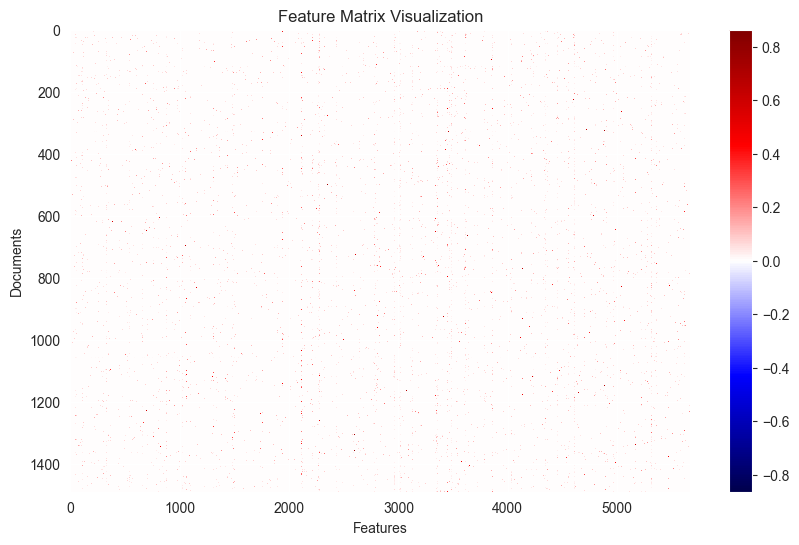

In [321]:
tfidf_extractor = TFIDFFeatureExtractor(cleaner)
tfidf_features = tfidf_extractor.extract_features()
tfidf_extractor.visualize_features(tfidf_features)
#selected_features_tfidf = tfidf_extractor.feature_selection(tfidf_extractor.data['Category'])
#tfidf_extractor.visualize_features(selected_features_tfidf)

From the visualization of the feature matrix visualization above, several key insights can be observed:

1) Sparsity: The image clearly displays the sparse nature of the matrix, with most of the points being blank (indicating zero values) and only a few points marked (indicating non-zero values). This is a typical characteristic of text data, especially when methods like word frequency or TF-IDF are used because not all words appear in every document.

2) Distribution of Data: The non-zero points are relatively dispersed, without clustering in specific areas, suggesting that no few features are universally present across all documents. This indicates a high degree of variability in how features (words) are used across different documents.

3) Feature Utilization: The distribution of non-zero points also implies that a broad range of features are utilized by some documents, although the frequency might not be high. This suggests that the feature extraction method (presumably TF-IDF) has successfully captured enough information to describe the contents of the dataset.


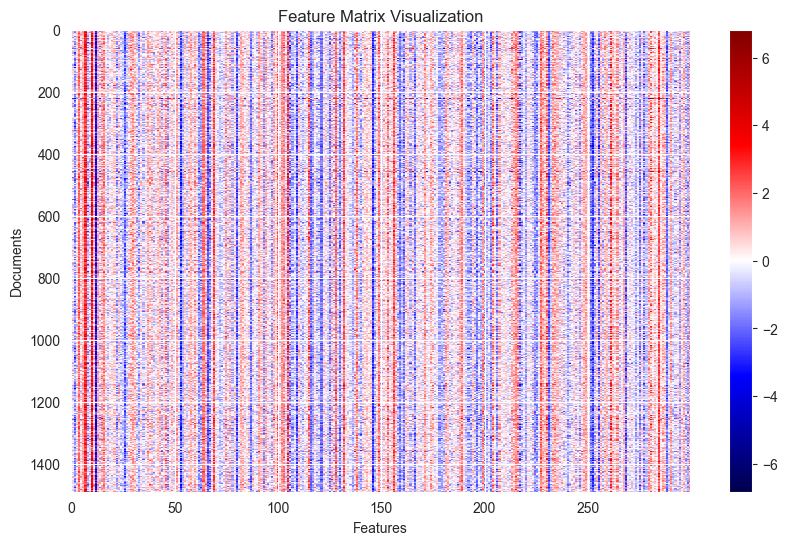

In [322]:
embedding_extractor = EmbeddingFeatureExtractor(cleaner)
embedding_features = embedding_extractor.extract_features()
embedding_extractor.visualize_features(embedding_features)
# Because the number of column has been 300, I temporarily not execute the following selection of feature process.
# selected_features_embedding = embedding_extractor.feature_selection(cleaner.train_data['Category'])

The visualization of the feature matrix derived from the EmbeddingFeatureExtractor shows some distinct patterns and characteristics worth analyzing:

1) Observations from the Visualization
Dense Representation: Unlike the sparse matrix typically seen with TF-IDF representations, the visualization here exhibits a more densely populated feature matrix. This denseness is a characteristic of embedding-based approaches where every word is represented by a dense vector, and every document vector is an aggregation (e.g., average) of these word vectors.

2) Patterns and Uniformity: There are visible patterns and blocks of uniformity across the matrix, which could indicate groups of documents with similar thematic content or stylistic features. The uniform blocks suggest that certain segments of features (or dimensions of the embeddings) are consistently active across several documents.

3) Feature Consistency: The presence of consistent horizontal lines across many documents could imply that certain dimensions in the word vectors are frequently activated. This might be indicative of common themes or linguistic structures prevalent across the dataset.


Then, let's implement factorization to generate the W and H matrix of each type of feature extraction.

Matrix W1 (document-topic weights): (1490, 5)
Matrix H1 (topic-feature weights): (5, 5669)


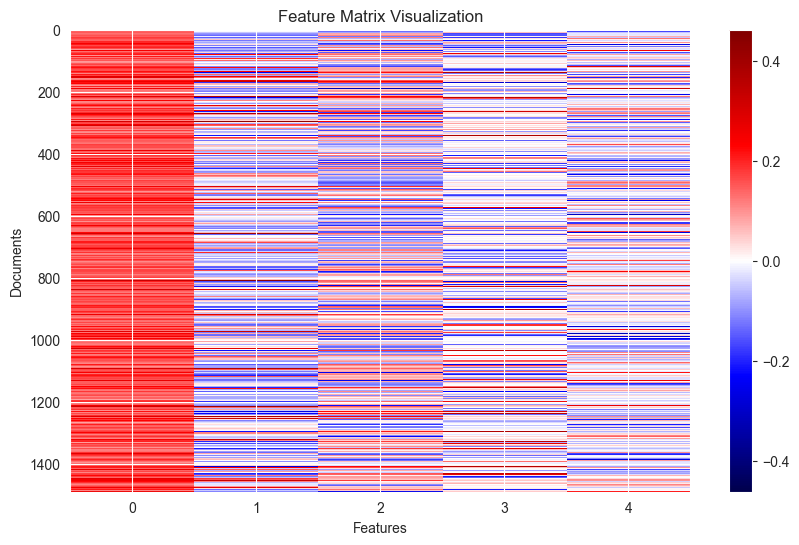

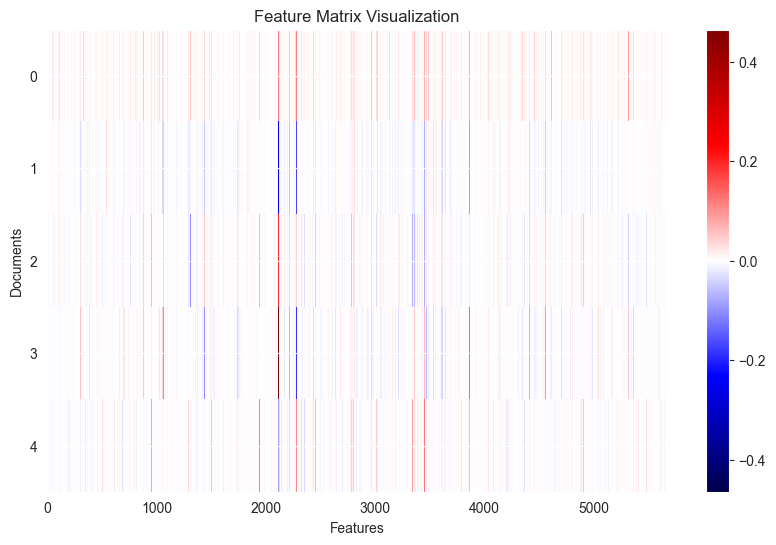

In [323]:
W1, H1 = tfidf_extractor.apply_matrix_factorization(method='SVD')

print("Matrix W1 (document-topic weights):", W1.shape)
print("Matrix H1 (topic-feature weights):", H1.shape)

tfidf_extractor.visualize_features(W1)
tfidf_extractor.visualize_features(H1)

Matrix W2 (document-topic weights): (1490, 5)
Matrix H2 (topic-feature weights): (5, 300)


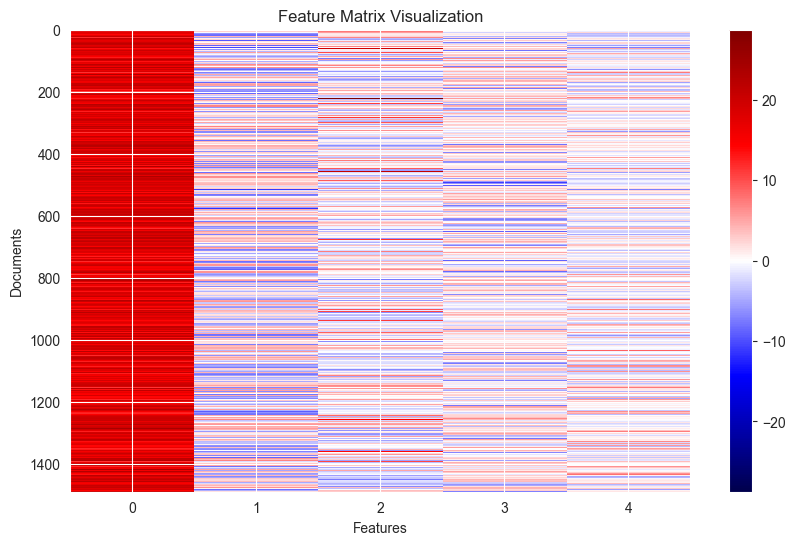

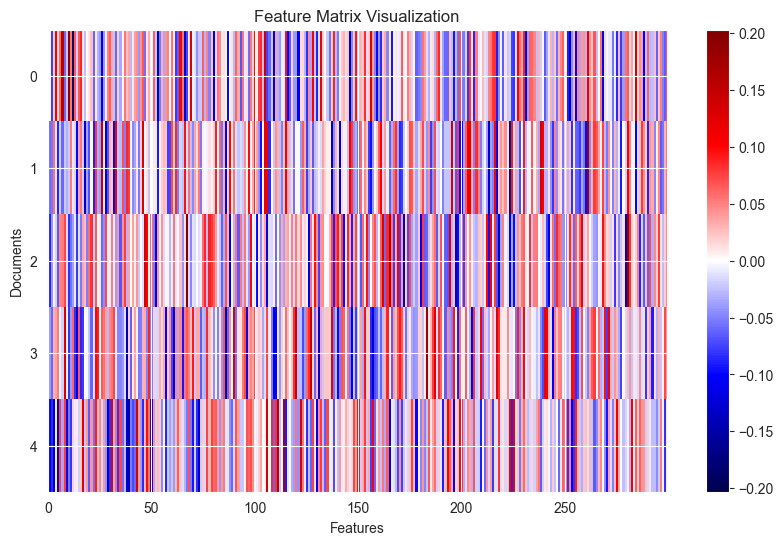

In [324]:
W2, H2 = embedding_extractor.apply_matrix_factorization(method='SVD')

print("Matrix W2 (document-topic weights):", W2.shape)
print("Matrix H2 (topic-feature weights):", H2.shape)

embedding_extractor.visualize_features(W2)
embedding_extractor.visualize_features(H2)

In the visualizations of the Singular Value Decomposition (SVD) applied to matrices generated from word embeddings and TF-IDF, we can observe unique characteristics in the resultant matrices W (document-topic weights) and H (topic-feature weights):

Axes Interpretation of W and H Matrices
W Matrix (Document-Topic Weights):

Rows: Each row corresponds to a document from the dataset, depicting how each document is represented in terms of the latent topics.
Columns: Each column represents a latent topic. The values in the matrix signify the extent to which a document relates to or is represented by each latent topic.

H Matrix (Topic-Feature Weights):

Rows: Each row corresponds to a latent topic identified by the SVD.
Columns: Each column represents a feature, typically words or terms in the case of text data. The values indicate how strongly each feature is associated with the latent topics.


Comparison of Results from TF-IDF and Word Embedding SVD
Intensity and Uniformity:

TF-IDF: The W matrix often exhibits more variation in the strength of document-topic associations across different topics, which can provide valuable insights for identifying dominant themes in documents. The H matrix from TF-IDF tends to show sparsity, highlighting the distinct contributions of specific terms to the topics.
Embeddings: Conversely, the embedding-based W matrix tends to display more uniformity, especially notable in the intense association of all documents with the first feature, potentially offering less granularity in distinguishing between different thematic structures. The H matrix is denser, showing a rich pattern of positive and negative associations, indicating a nuanced interplay of features that captures both semantic and syntactic nuances.

Implications

Interpretability: TF-IDF matrices are often easier to interpret since each feature directly correlates to a term whose significance is straightforward to understand within a topic context. In contrast, the matrices derived from embeddings require deeper analysis to interpret, as the features represent complex, abstract dimensions of the data.
Applicability: Choosing between TF-IDF and embeddings for conducting SVD should be influenced by the specific requirements of the analysis or application. TF-IDF may be more suitable for applications that demand direct interpretability and identification of key terms. In contrast, embeddings might be favored for applications that require a comprehensive understanding of text based on underlying semantic and syntactic patterns.

After the feature extraction process and the outcome of W and H matrix of the two type of feature matrix, I then implement step 2 of building and training models.

Step 2: Building and training models

I would like to answer the first question of guidance:
1.Think about this and answer: when you train the unsupervised model for matrix factorization, should you include texts (word features) from the test dataset or not as the input matrix? Why or why not?
Answer: Obviously, we should not include texts from test dataset as the input matrix to ensure the independence and generalizability of the model evaluation. Because if we include the testing data, the independence of testing data will be broken, and thus the result of our model would be not reliable.

Next, I would follow the guidance to 
2.build a model using the matrix factorization method(s),
3.measure the performances on predictions from both train and test datasets, 

In [362]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix
from itertools import permutations
import os
from datetime import datetime
import time
from kaggle.api.kaggle_api_extended import KaggleApi

class ModelTrainer:
    def __init__(self, feature_extractor):
        self.extractor = feature_extractor
        self.model = self.extractor.model
        self.W = self.extractor.W
        self.H = self.extractor.H
        self.cluster_model = None
        self.label_mapping = self.extractor.label_mapping
        self.inverse_label_mapping = self.extractor.inverse_label_mapping
        self.cluster_to_label_mapping = {}  # 新增的映射变量
        self.performance_log = []

    def cluster_documents(self, n_clusters=5):
        self.cluster_model = KMeans(n_clusters=n_clusters, random_state=42)
        self.cluster_model.fit(self.W)
        return self.cluster_model.labels_

    def find_best_label_mapping(self, true_labels, predicted_labels):
        unique_labels = np.unique(true_labels)
        best_mapping = None
        best_accuracy = 0
        best_mapped_labels = None

        for perm in permutations(unique_labels):
            label_mapping = {i: perm[i] for i in range(len(unique_labels))}
            mapped_labels = [label_mapping[label] for label in predicted_labels]
            accuracy = accuracy_score(true_labels, mapped_labels)
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_mapping = label_mapping
                best_mapped_labels = mapped_labels

        return best_mapping, best_mapped_labels, best_accuracy
    
    @staticmethod
    def submit_to_kaggle_and_get_score(competition, filename, message):
        api = KaggleApi()
        api.authenticate()
        api.competition_submit(file_name=filename, competition=competition, message=message)

    def evaluate_performance(self, true_labels):
        if true_labels is None:
            raise ValueError("True labels are not provided.")

        true_labels = true_labels.astype(int)
        predicted_labels = self.cluster_documents(n_clusters=len(np.unique(true_labels)))
        self.cluster_to_label_mapping, mapped_labels, best_accuracy = self.find_best_label_mapping(true_labels, predicted_labels)

        conf_matrix = confusion_matrix(true_labels, mapped_labels)
        print("Best Accuracy:", best_accuracy)
        print("Confusion Matrix:\n", conf_matrix)

        self.plot_confusion_matrix(conf_matrix, np.unique(true_labels))

        self.performance_log.append({
            'n_clusters': len(np.unique(true_labels)),
            'accuracy': best_accuracy,
            'confusion_matrix': conf_matrix
        })

        return best_accuracy, conf_matrix

    def predict_batch(self, new_data):
        """Transform and predict labels for a batch of new data."""
        new_features = self.model.transform(new_data)
        predicted_labels = self.cluster_model.predict(new_features)
        return predicted_labels

    def predict_new(self):
        if self.extractor.test_data is None:
            raise ValueError("Test data is not available.")

        if isinstance(self.extractor, TFIDFFeatureExtractor):
            test_features = self.extractor.vectorizer.transform(self.extractor.test_data['Processed_Text'])
        elif isinstance(self.extractor, EmbeddingFeatureExtractor):
            test_features = np.array([self.extractor.document_vector(text) for text in self.extractor.test_data['Processed_Text']])
        else:
            raise ValueError("Unsupported feature extractor type.")

        predicted_labels = self.predict_batch(test_features)

        # 使用 self.cluster_to_label_mapping 将聚类标签转换为数字标签
        numeric_labels = [self.cluster_to_label_mapping[label] for label in predicted_labels]

        # 使用 self.extractor.inverse_label_mapping 将数字标签转换为原始标签名
        predicted_categories = [self.extractor.inverse_label_mapping[label] for label in numeric_labels]

        submission = pd.DataFrame({
            'ArticleId': self.extractor.test_data['ArticleId'],
            'Category': predicted_categories
        })
        submission.to_csv('submission.csv', index=False)
        print("Submission file created: submission.csv")
        self.submit_to_kaggle_and_get_score(competition='learn-ai-bbc', filename='submission.csv', message='Message')

    def plot_confusion_matrix(self, cm, labels):
        plt.figure(figsize=(10, 7))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()

    def plot_cluster_distribution(self, predicted_labels):
        plt.figure(figsize=(10, 7))
        sns.countplot(predicted_labels)
        plt.xlabel('Cluster')
        plt.ylabel('Number of Documents')
        plt.title('Distribution of Documents Across Clusters')
        plt.show()

    def visualize_feature_matrices(self):
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 2, 1)
        sns.heatmap(self.W, cmap='viridis')
        plt.title('W Matrix (Document-Topic)')

        plt.subplot(1, 2, 2)
        sns.heatmap(self.H, cmap='viridis')
        plt.title('H Matrix (Topic-Term)')

        plt.show()

    def tune_hyperparameters(self, true_labels, num_features_list):
        best_accuracy = 0
        best_num_features = None

        for num_features in num_features_list:
            self.extractor.feature_selection(true_labels, num_features)
            self.W = self.extractor.W
            self.H = self.extractor.H

            accuracy, _ = self.evaluate_performance(true_labels)

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_num_features = num_features

            self.performance_log.append({
                'num_features': num_features,
                'accuracy': accuracy
            })

        print(f"Best number of features: {best_num_features} with accuracy: {best_accuracy}")
        return best_num_features, best_accuracy

    def plot_performance_log(self):
        num_features = [log['num_features'] for log in self.performance_log if 'num_features' in log]
        accuracies = [log['accuracy'] for log in self.performance_log if 'accuracy' in log]

        plt.figure(figsize=(10, 7))
        plt.plot(num_features, accuracies, marker='o')
        plt.xlabel('Number of Features')
        plt.ylabel('Accuracy')
        plt.title('Performance Across Different Number of Features')
        plt.grid(True)
        plt.show()

Best Accuracy: 0.7906040268456376
Confusion Matrix:
 [[278  53   2   3   0]
 [  0 249   1   9   2]
 [ 10  80 181   3   0]
 [  0   7   0 339   0]
 [  2 138   0   2 131]]


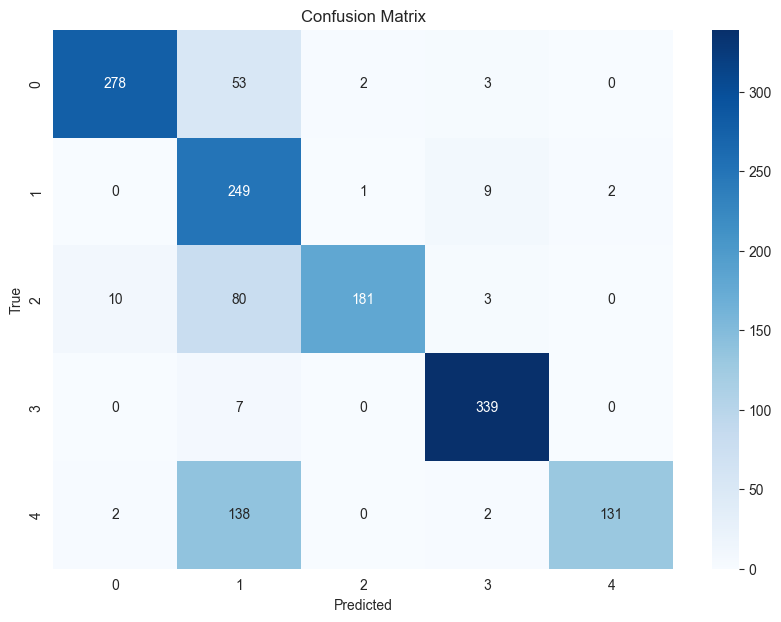

Submission file created: submission.csv


100%|██████████| 9.10k/9.10k [00:01<00:00, 6.77kB/s]


In [363]:
tfidf_trainer = ModelTrainer(tfidf_extractor)
true_labels = tfidf_extractor.data['Category']  # Accessing the true categories directly
tfidf_trainer.evaluate_performance(true_labels)
tfidf_trainer.predict_new()


The submission above scored 0.78367 according to the website of kaggle, which is close to the performance of training data.

Best Accuracy: 0.6798657718120805
Confusion Matrix:
 [[243   4  49   1  39]
 [ 13 212  16  10  10]
 [ 40   1 222   9   2]
 [  1   0  27 305  13]
 [  1   7  15 219  31]]


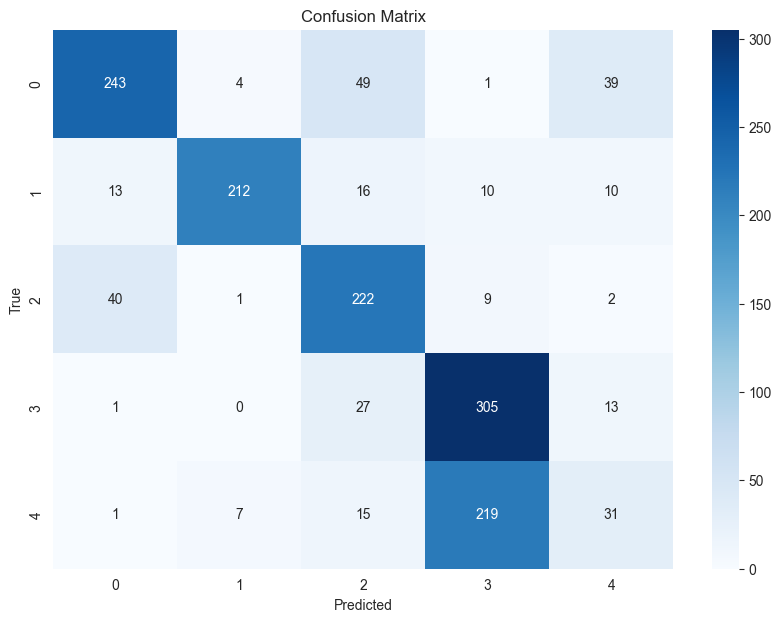

Submission file created: submission.csv


100%|██████████| 9.52k/9.52k [00:01<00:00, 8.92kB/s]


In [364]:
embedding_trainer = ModelTrainer(embedding_extractor)
embedding_trainer.evaluate_performance(true_labels)
embedding_trainer.predict_new()

The submission above scored 0.68843 according to the website of kaggle, which is close to the performance of training data.

Let me compare the two matrix:

The TF-IDF model outperforms the word embedding model in terms of both training and test set accuracy. The confusion matrices show that the TF-IDF model makes fewer misclassifications across different categories. This is likely due to the high-dimensional feature space provided by TF-IDF, which captures more specific information about word frequencies and their relevance in the context of the articles.

The word embedding model, while capturing semantic information and providing a more compact representation (300 features), does not achieve the same level of accuracy as the TF-IDF model. This might be due to the fact that the embedding dimensions, though capturing semantic relationships, do not sufficiently capture the nuances of word usage frequency and importance in distinguishing between news categories.

For the task of news article classification, the TF-IDF model with 5000 features demonstrates superior performance compared to the word embedding model with 300 features. The higher accuracy and better performance in the confusion matrix indicate that TF-IDF is more effective for this particular classification task.

To further improve model performance, consider the following steps, mapping to the guidance 4) and 5):
1) Tune Hyperparameters: Change the number of features selected and the number of components in matrix factorization to find the optimal combination.
2) Ensemble Methods: Combine TF-IDF and word embedding features to build a stronger ensemble model, leveraging the strengths of both methods.


In [365]:
# Hyperparameter tuning
num_features_list = [25,50,100,150,200,250]
component_range = [5, 10, 15, 20]

best_num_features, best_accuracy = embedding_trainer.tune_hyperparameters(embedding_trainer.extractor.data['Category'], num_features_list, component_range)
# Plot performance log
embedding_trainer.plot_performance_log()

TypeError: tune_hyperparameters() takes 3 positional arguments but 4 were given

Best Accuracy: 0.648993288590604
Confusion Matrix:
 [[190 144   0   2   0]
 [  0 236   1  22   2]
 [  1 144 125   4   0]
 [  0  44   0 302   0]
 [  2 154   0   3 114]]


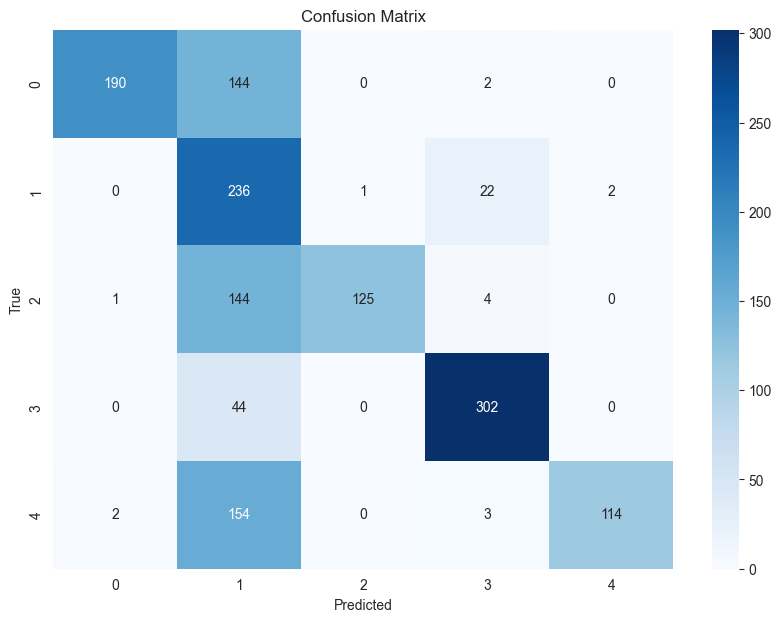

Best Accuracy: 0.648993288590604
Confusion Matrix:
 [[190 144   0   2   0]
 [  0 236   1  22   2]
 [  1 144 125   4   0]
 [  0  44   0 302   0]
 [  2 154   0   3 114]]


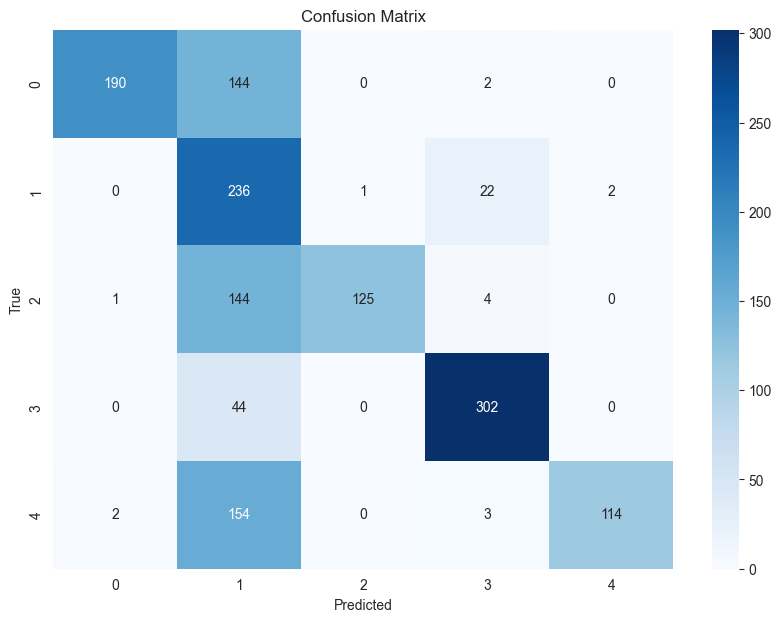

Best Accuracy: 0.648993288590604
Confusion Matrix:
 [[190 144   0   2   0]
 [  0 236   1  22   2]
 [  1 144 125   4   0]
 [  0  44   0 302   0]
 [  2 154   0   3 114]]


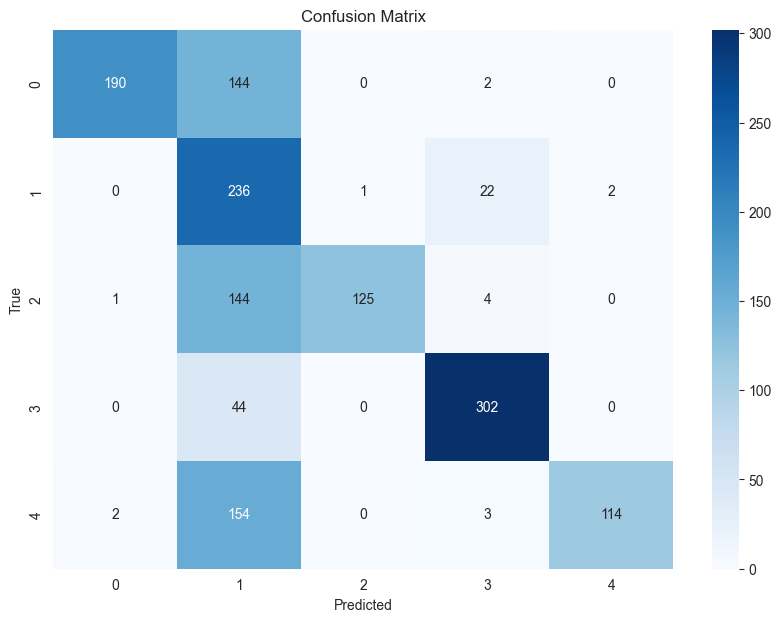

Best Accuracy: 0.648993288590604
Confusion Matrix:
 [[190 144   0   2   0]
 [  0 236   1  22   2]
 [  1 144 125   4   0]
 [  0  44   0 302   0]
 [  2 154   0   3 114]]


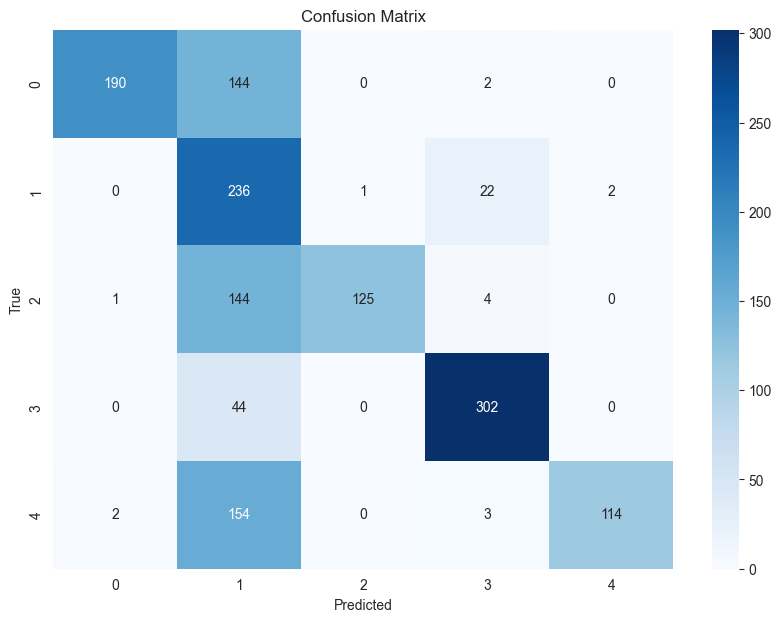

K:\CU boulder\projects\BBC news classification\.venv\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=50 is greater than n_features=25. All the features will be returned.
  warnings.warn(


Best Accuracy: 0.648993288590604
Confusion Matrix:
 [[190 144   0   2   0]
 [  0 236   1  22   2]
 [  1 144 125   4   0]
 [  0  44   0 302   0]
 [  2 154   0   3 114]]


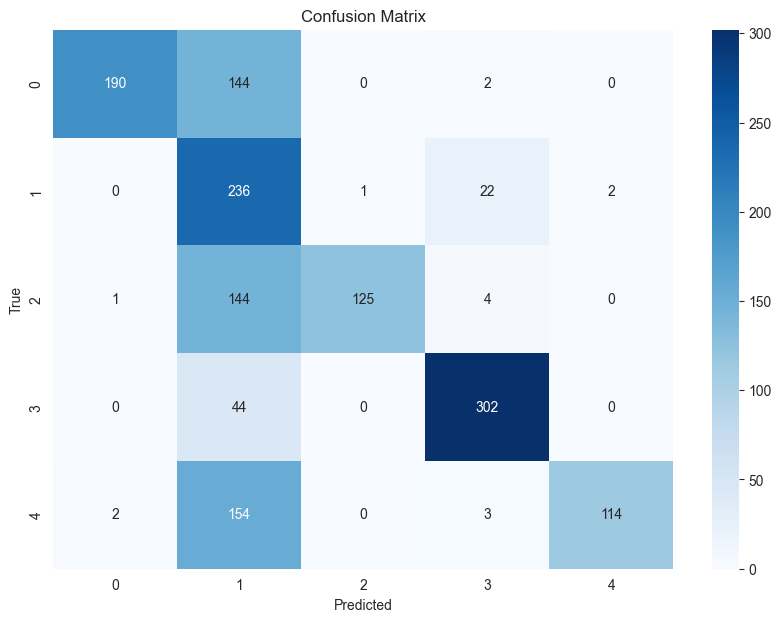

K:\CU boulder\projects\BBC news classification\.venv\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=50 is greater than n_features=25. All the features will be returned.
  warnings.warn(


Best Accuracy: 0.648993288590604
Confusion Matrix:
 [[190 144   0   2   0]
 [  0 236   1  22   2]
 [  1 144 125   4   0]
 [  0  44   0 302   0]
 [  2 154   0   3 114]]


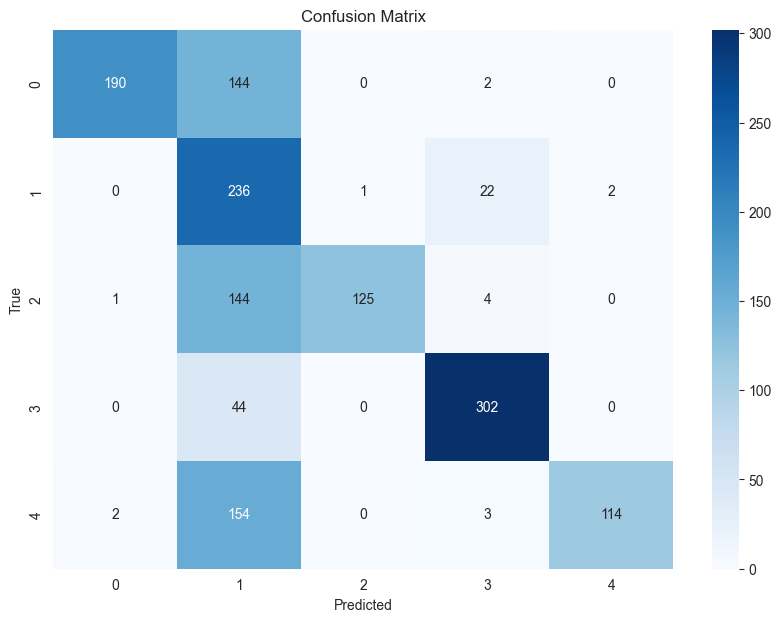

K:\CU boulder\projects\BBC news classification\.venv\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=50 is greater than n_features=25. All the features will be returned.
  warnings.warn(


Best Accuracy: 0.648993288590604
Confusion Matrix:
 [[190 144   0   2   0]
 [  0 236   1  22   2]
 [  1 144 125   4   0]
 [  0  44   0 302   0]
 [  2 154   0   3 114]]


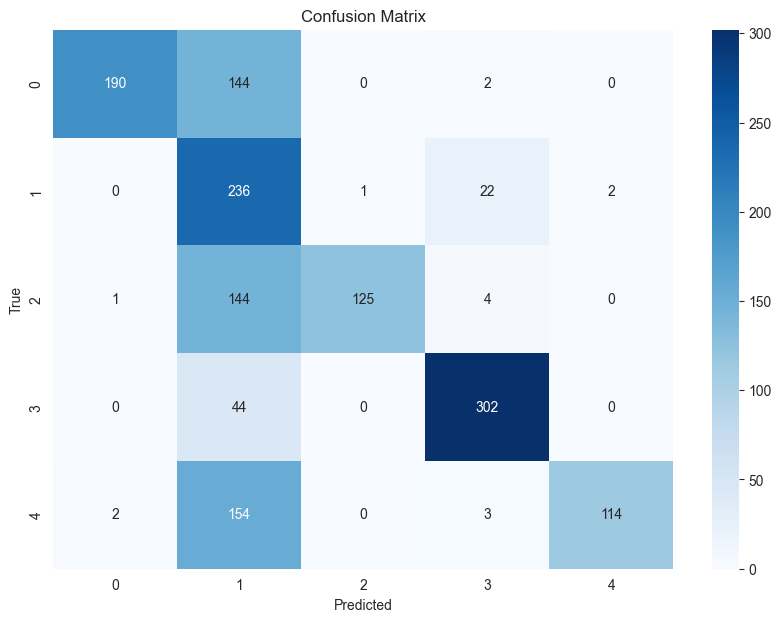

K:\CU boulder\projects\BBC news classification\.venv\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=50 is greater than n_features=25. All the features will be returned.
  warnings.warn(


Best Accuracy: 0.648993288590604
Confusion Matrix:
 [[190 144   0   2   0]
 [  0 236   1  22   2]
 [  1 144 125   4   0]
 [  0  44   0 302   0]
 [  2 154   0   3 114]]


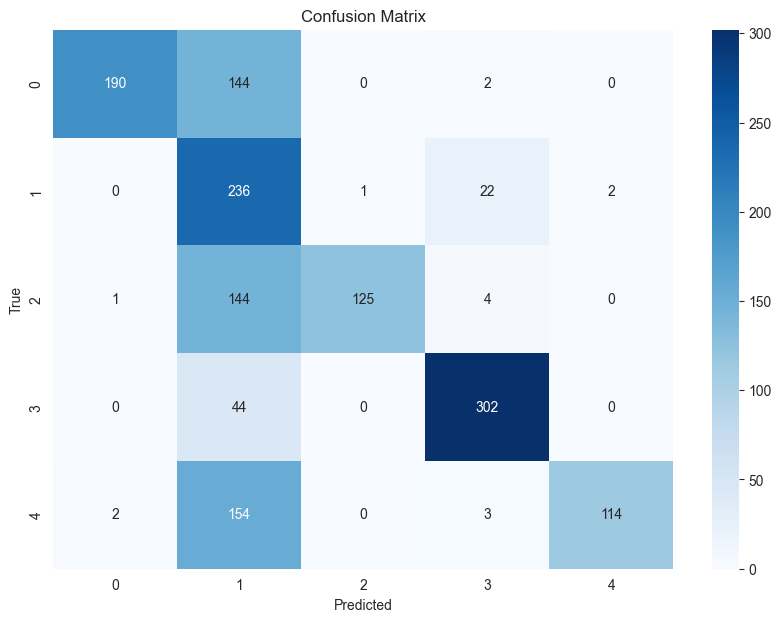

K:\CU boulder\projects\BBC news classification\.venv\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=100 is greater than n_features=25. All the features will be returned.
  warnings.warn(


Best Accuracy: 0.648993288590604
Confusion Matrix:
 [[190 144   0   2   0]
 [  0 236   1  22   2]
 [  1 144 125   4   0]
 [  0  44   0 302   0]
 [  2 154   0   3 114]]


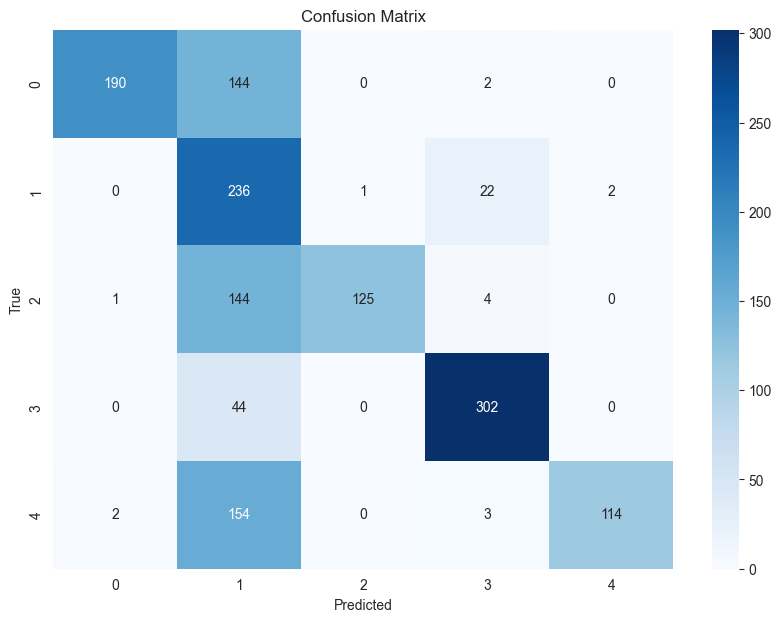

K:\CU boulder\projects\BBC news classification\.venv\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=100 is greater than n_features=25. All the features will be returned.
  warnings.warn(


Best Accuracy: 0.648993288590604
Confusion Matrix:
 [[190 144   0   2   0]
 [  0 236   1  22   2]
 [  1 144 125   4   0]
 [  0  44   0 302   0]
 [  2 154   0   3 114]]


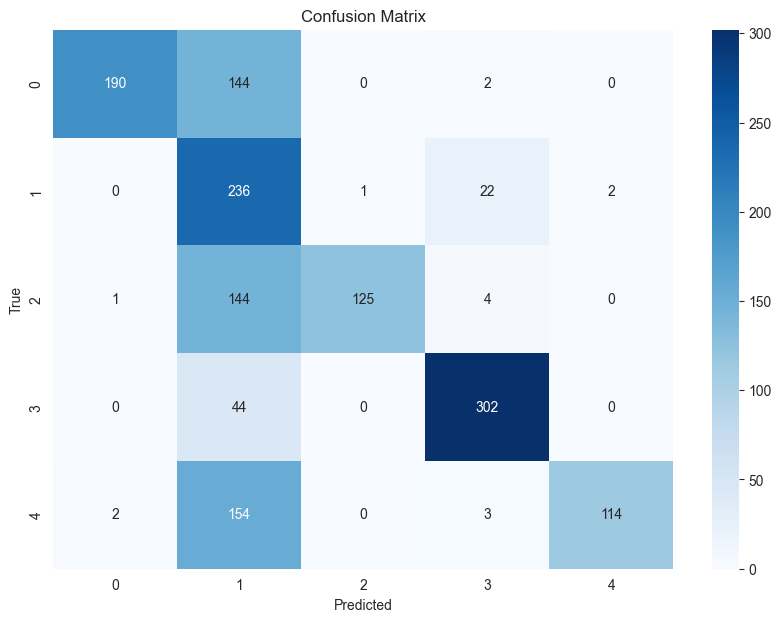

K:\CU boulder\projects\BBC news classification\.venv\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=100 is greater than n_features=25. All the features will be returned.
  warnings.warn(


Best Accuracy: 0.648993288590604
Confusion Matrix:
 [[190 144   0   2   0]
 [  0 236   1  22   2]
 [  1 144 125   4   0]
 [  0  44   0 302   0]
 [  2 154   0   3 114]]


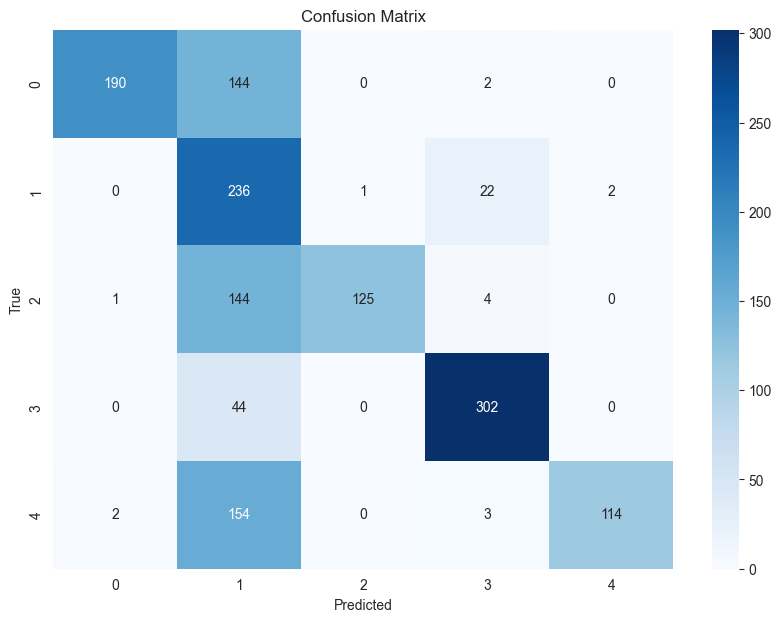

K:\CU boulder\projects\BBC news classification\.venv\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=100 is greater than n_features=25. All the features will be returned.
  warnings.warn(


Best Accuracy: 0.648993288590604
Confusion Matrix:
 [[190 144   0   2   0]
 [  0 236   1  22   2]
 [  1 144 125   4   0]
 [  0  44   0 302   0]
 [  2 154   0   3 114]]


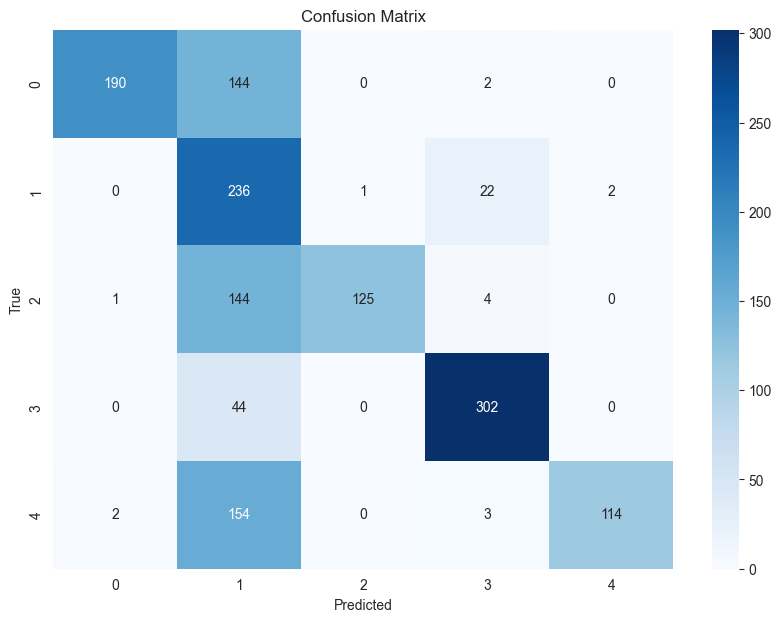

K:\CU boulder\projects\BBC news classification\.venv\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=150 is greater than n_features=25. All the features will be returned.
  warnings.warn(


Best Accuracy: 0.648993288590604
Confusion Matrix:
 [[190 144   0   2   0]
 [  0 236   1  22   2]
 [  1 144 125   4   0]
 [  0  44   0 302   0]
 [  2 154   0   3 114]]


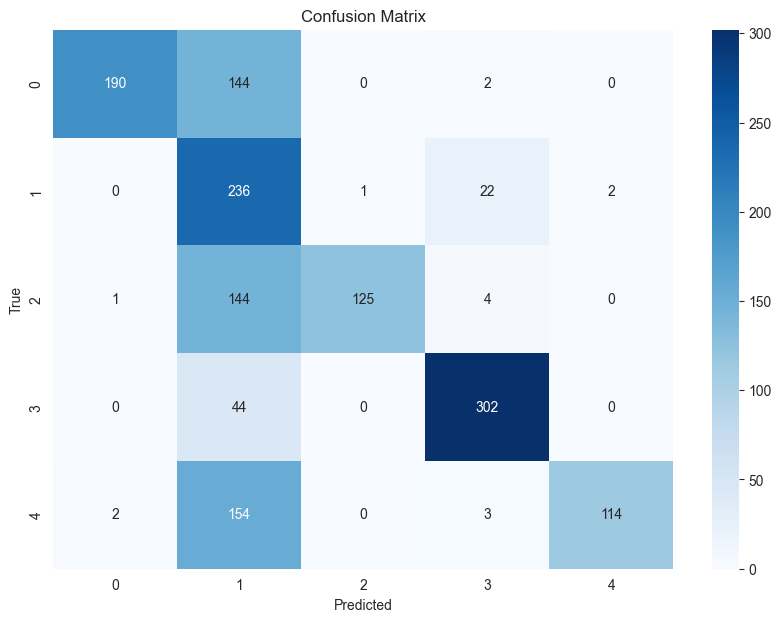

K:\CU boulder\projects\BBC news classification\.venv\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=150 is greater than n_features=25. All the features will be returned.
  warnings.warn(


Best Accuracy: 0.648993288590604
Confusion Matrix:
 [[190 144   0   2   0]
 [  0 236   1  22   2]
 [  1 144 125   4   0]
 [  0  44   0 302   0]
 [  2 154   0   3 114]]


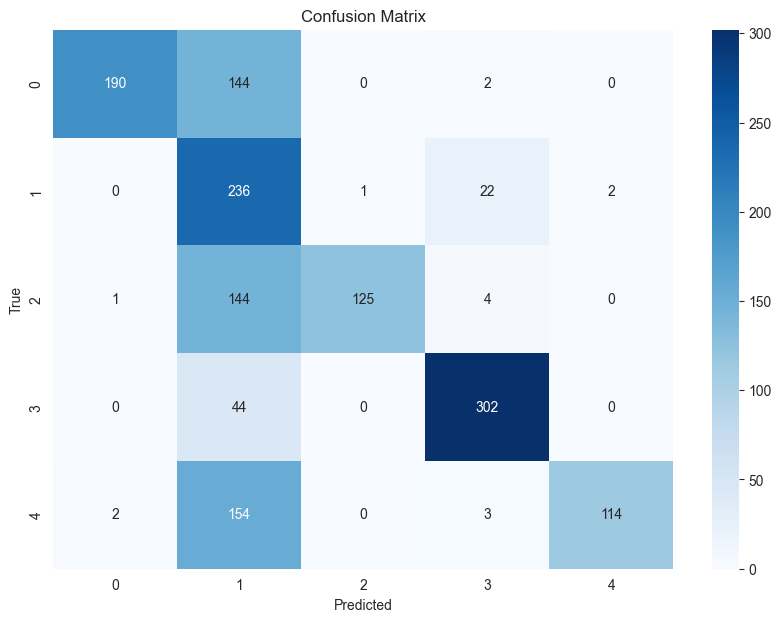

K:\CU boulder\projects\BBC news classification\.venv\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=150 is greater than n_features=25. All the features will be returned.
  warnings.warn(


Best Accuracy: 0.648993288590604
Confusion Matrix:
 [[190 144   0   2   0]
 [  0 236   1  22   2]
 [  1 144 125   4   0]
 [  0  44   0 302   0]
 [  2 154   0   3 114]]


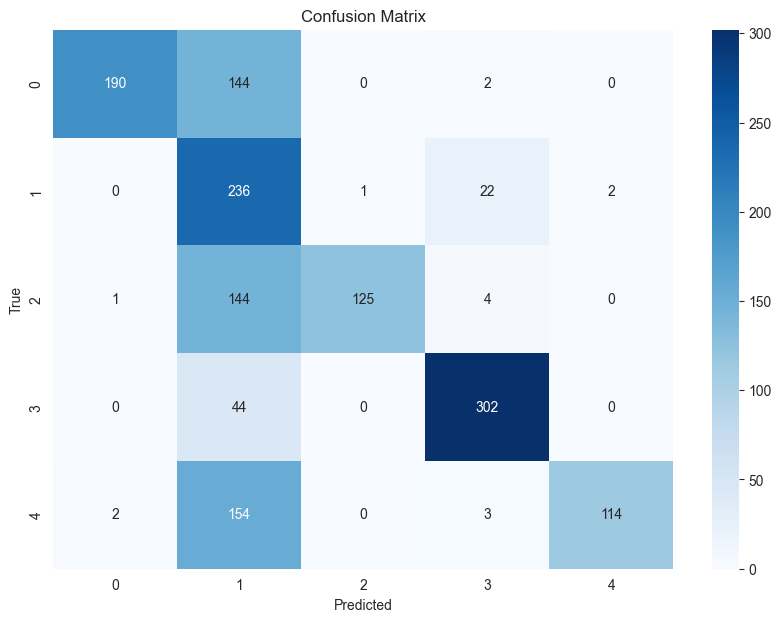

K:\CU boulder\projects\BBC news classification\.venv\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=150 is greater than n_features=25. All the features will be returned.
  warnings.warn(


Best Accuracy: 0.648993288590604
Confusion Matrix:
 [[190 144   0   2   0]
 [  0 236   1  22   2]
 [  1 144 125   4   0]
 [  0  44   0 302   0]
 [  2 154   0   3 114]]


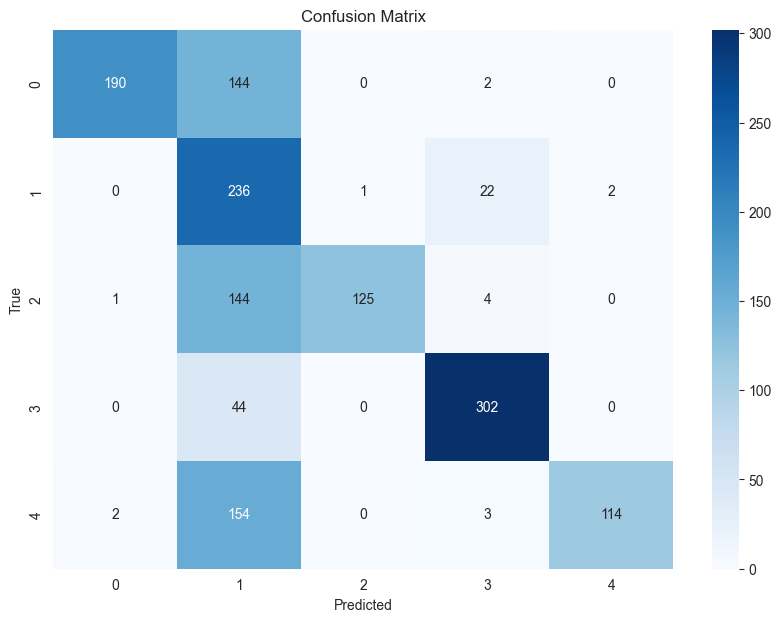

K:\CU boulder\projects\BBC news classification\.venv\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=200 is greater than n_features=25. All the features will be returned.
  warnings.warn(


Best Accuracy: 0.648993288590604
Confusion Matrix:
 [[190 144   0   2   0]
 [  0 236   1  22   2]
 [  1 144 125   4   0]
 [  0  44   0 302   0]
 [  2 154   0   3 114]]


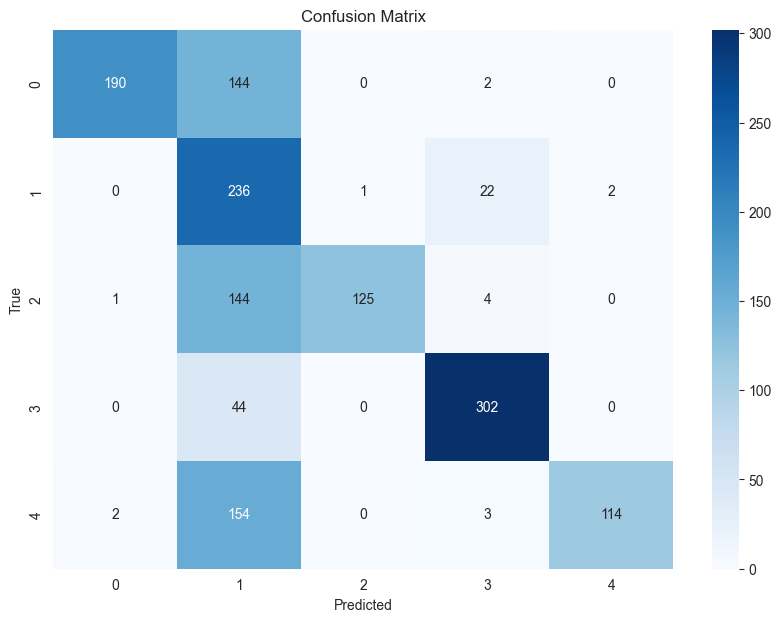

K:\CU boulder\projects\BBC news classification\.venv\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=200 is greater than n_features=25. All the features will be returned.
  warnings.warn(


Best Accuracy: 0.648993288590604
Confusion Matrix:
 [[190 144   0   2   0]
 [  0 236   1  22   2]
 [  1 144 125   4   0]
 [  0  44   0 302   0]
 [  2 154   0   3 114]]


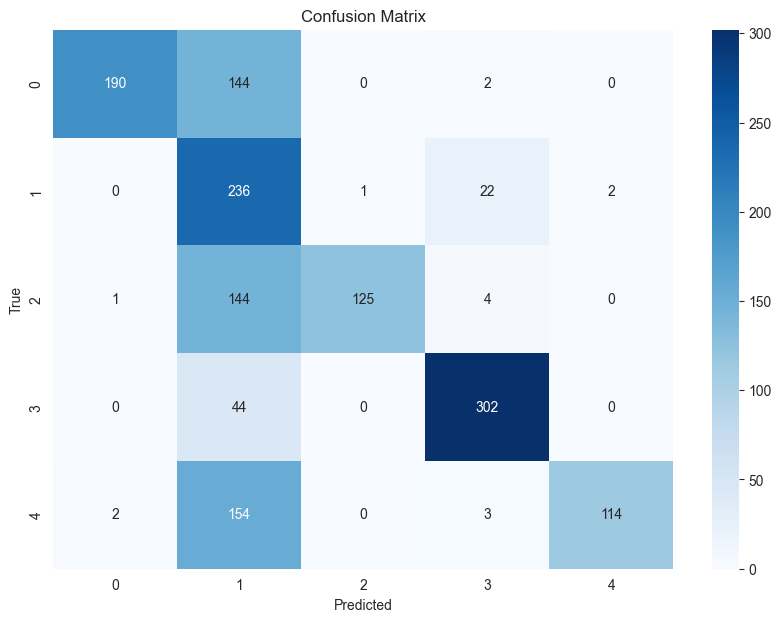

K:\CU boulder\projects\BBC news classification\.venv\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=200 is greater than n_features=25. All the features will be returned.
  warnings.warn(


Best Accuracy: 0.648993288590604
Confusion Matrix:
 [[190 144   0   2   0]
 [  0 236   1  22   2]
 [  1 144 125   4   0]
 [  0  44   0 302   0]
 [  2 154   0   3 114]]


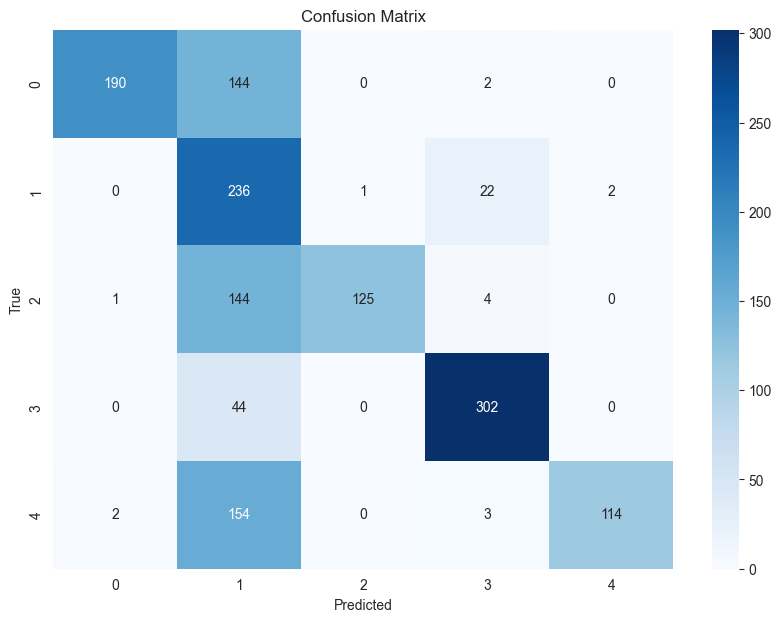

K:\CU boulder\projects\BBC news classification\.venv\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=200 is greater than n_features=25. All the features will be returned.
  warnings.warn(


Best Accuracy: 0.648993288590604
Confusion Matrix:
 [[190 144   0   2   0]
 [  0 236   1  22   2]
 [  1 144 125   4   0]
 [  0  44   0 302   0]
 [  2 154   0   3 114]]


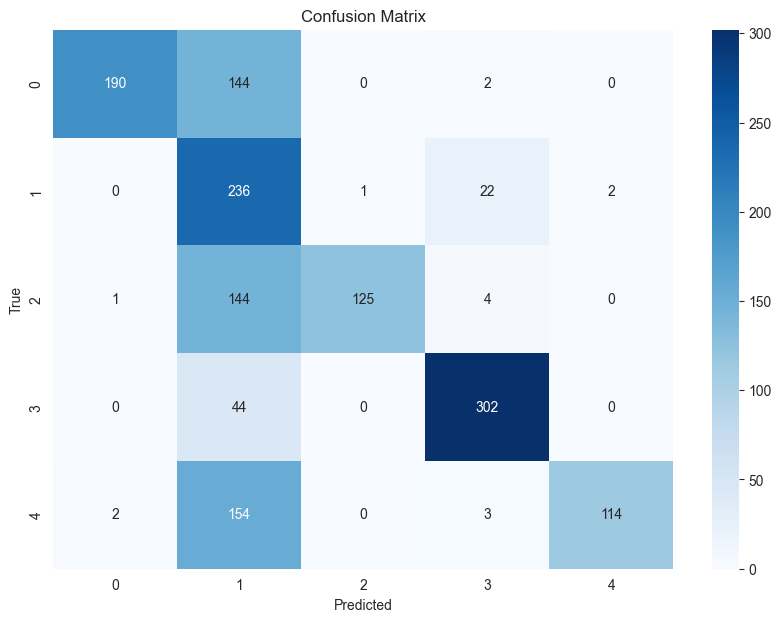

K:\CU boulder\projects\BBC news classification\.venv\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=250 is greater than n_features=25. All the features will be returned.
  warnings.warn(


Best Accuracy: 0.648993288590604
Confusion Matrix:
 [[190 144   0   2   0]
 [  0 236   1  22   2]
 [  1 144 125   4   0]
 [  0  44   0 302   0]
 [  2 154   0   3 114]]


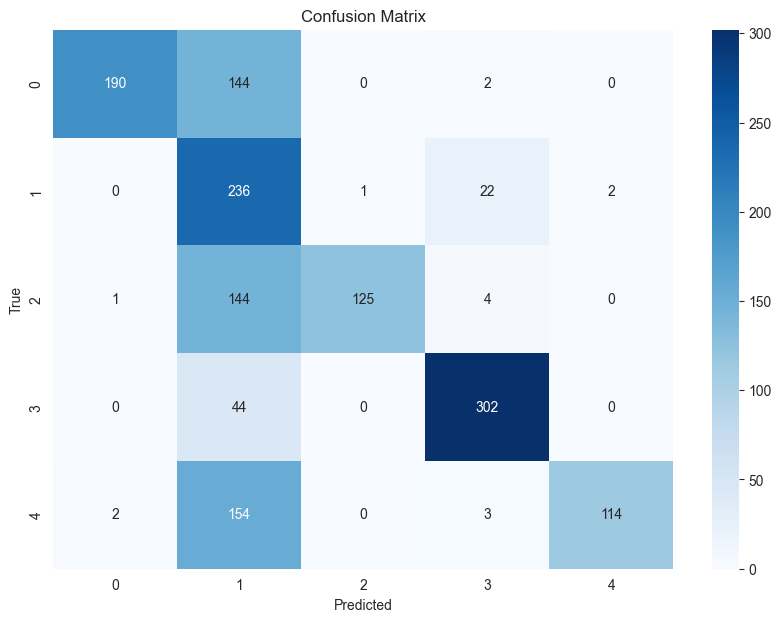

K:\CU boulder\projects\BBC news classification\.venv\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=250 is greater than n_features=25. All the features will be returned.
  warnings.warn(


Best Accuracy: 0.648993288590604
Confusion Matrix:
 [[190 144   0   2   0]
 [  0 236   1  22   2]
 [  1 144 125   4   0]
 [  0  44   0 302   0]
 [  2 154   0   3 114]]


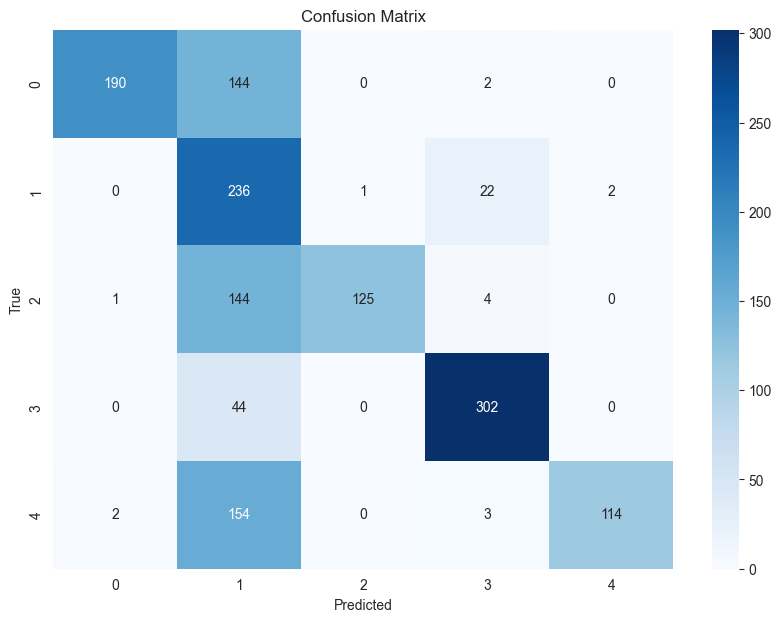

K:\CU boulder\projects\BBC news classification\.venv\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=250 is greater than n_features=25. All the features will be returned.
  warnings.warn(


Best Accuracy: 0.648993288590604
Confusion Matrix:
 [[190 144   0   2   0]
 [  0 236   1  22   2]
 [  1 144 125   4   0]
 [  0  44   0 302   0]
 [  2 154   0   3 114]]


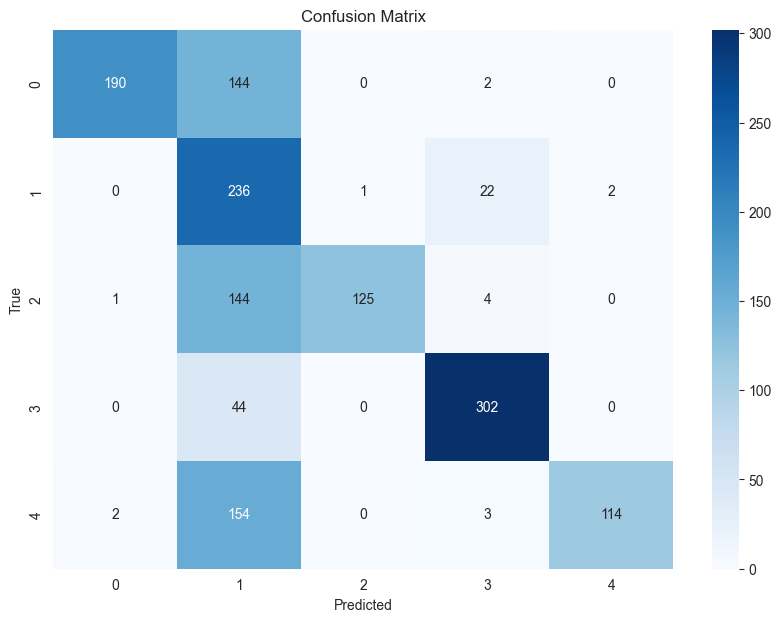

K:\CU boulder\projects\BBC news classification\.venv\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=250 is greater than n_features=25. All the features will be returned.
  warnings.warn(


Best Accuracy: 0.648993288590604
Confusion Matrix:
 [[190 144   0   2   0]
 [  0 236   1  22   2]
 [  1 144 125   4   0]
 [  0  44   0 302   0]
 [  2 154   0   3 114]]


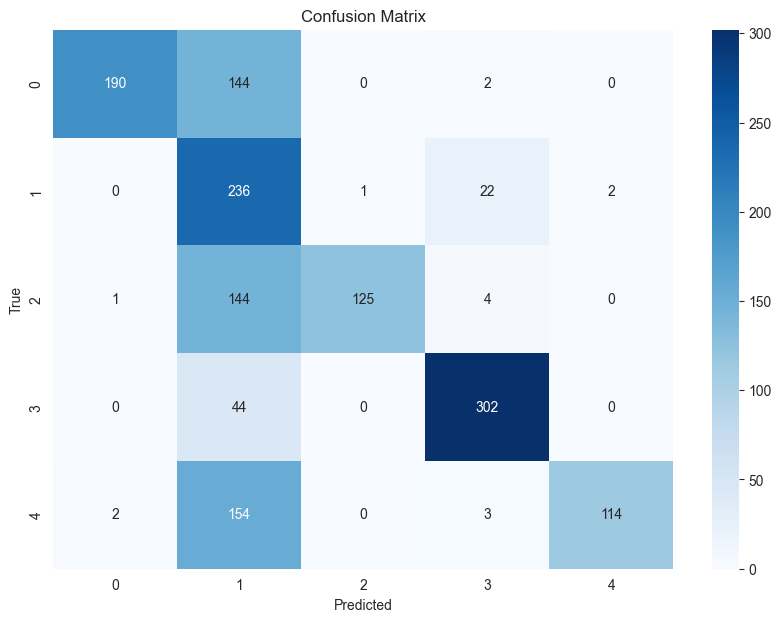

Best hyperparameters: {'num_features': 25, 'n_components': 5} with accuracy: 0.648993288590604


ValueError: x and y must have same first dimension, but have shapes (0,) and (1,)

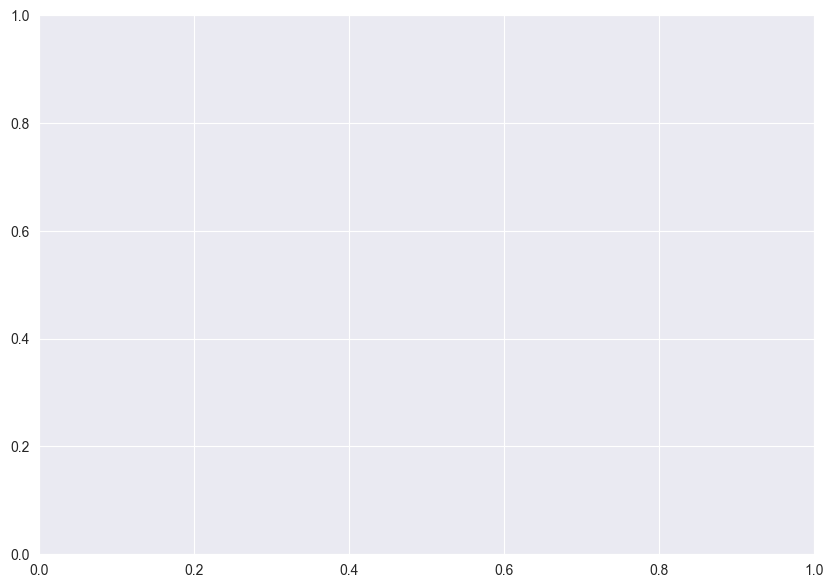

In [198]:
# Hyperparameter tuning
num_features_list = [25,50,100,150,200,250]
best_num_features, best_accuracy = tfidf_trainer.tune_hyperparameters(true_labels, num_features_list)
# Plot performance log
embedding_trainer.plot_performance_log()